## EEP 153 Project 4

In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems. The goal of this project is to analyze the differences in diet within the population of Senegal based on household characteristics. After estimating a demand system for Senegal, we want to investigate the relationship between diet, budget, and prices.

There are two prerequisites; the first is the `CFEDemands` python
module.  The following code installs this module:

In [1]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Our country of interest is Senegal. Professor Ligon provided a spreadsheet with household characteristics, food expenditures, and food prices for Senegal that can be found at https://docs.google.com/spreadsheets/d/1s01A3lSZdlcHQPIfJcLdI3k-NtQkTInia1fDAg7W5eQ/

In order to conduct nutritional analysis, we added columns for Recommended Daily Intake and Food Composition tables and created a new spreadsheet for Senegal that can be found at https://docs.google.com/spreadsheets/d/1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E/


#### Structure of the Spreadsheet



Our spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
includes a household id; the column &ldquo;t&rdquo; includes an
indicator for the year or period (e.g., 2019);
the column &ldquo;m&rdquo; is an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Senegal&rdquo;).

The triple (i,t,m) serves as the index of the constructed
dataframes.  

Before manipulating the data, we had to preprocess it by saving each sheet as its own CSV and translating the food names from French to English.

#### From Sheet to DataFrame to Regression Object



We begin by loading in our CSVs for each respective worksheet in our main Senegal spreadsheet and converting them to dataframes.



In [37]:
import pandas as pd
import numpy as np
import cfe

In [98]:
#constants
hhc = get_clean_sheet(f'./Data/Malawi_Household_Characteristics.csv')
hhc.columns = hhc.columns.str.replace("Females", "F").str.replace("Males", "M")
hhc.columns = hhc.columns.str.replace("51-99", "51+")

In [41]:

def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures by year
def nutritional_yearly_analysis(year_range, hhc):
    expend = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    exp = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    
    exp_wide = expend.pivot_table(
        index=["i", "t", "m"],   # The keys identifying each row
        columns="j",            # The column you want to spread out
        values="Expenditure",   # What goes in the cells
        aggfunc="sum",          # How to aggregate if you have repeats
    )
    
    # If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
    expend = exp_wide.reset_index()
    
    if 'm' not in expend.columns:
        expend['m'] = 1
    
    expend = expend.set_index(['i','t','m'])
    expend.columns.name = 'j'
    
    expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    expend = expend.replace(0,np.nan)
    
    # Get HH characteristics...
    #hhc = get_clean_sheet(f'./Data/Malawi_Household_Characteristics.csv')
    d = hhc.copy()
    
    d.set_index(['i', 't', 'm'], inplace=True)
    #d = d.drop(columns=["Unnamed: 0"])
    d.columns.name = 'k'

    if 'm' not in hhc.columns:
        hhc['m'] = 1
    
    hhc1 = hhc.copy()
    hhc1 = hhc1.set_index(['i','t','m'])
    hhc1.columns.name = 'k'
    hhc1 = hhc1.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    
    # Group expenditures and clean
    # Group expenditures and clean
    x = pd.read_csv(f"./Data/Malawi_Food_Expenditures({year_range}).csv", header= 0, index_col=0).reset_index()
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    
    # Take logs of expenditures
    y = np.log(x)
    
    result = Regression(y=y,d=d)
    # Save the regression result
    result.to_pickle(f'malawi_estimates({year_range}).rgsn')
    
    # Get prices
    p = pd.read_csv(f"./Data/Malawi_Food_Prices({year_range}).csv")
    
    # Make sure we have 't', 'm', 'j', 'Price' columns (drop 'Unnamed' if needed)
    #p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")
    
    # Convert to numeric if needed
    p["Price"] = pd.to_numeric(p["Price"], errors="coerce")
    
    # Pivot so each unique `j` becomes a column and
    # each (t, m) is one row
    p_wide = p.pivot_table(
        index=["t","m"],
        columns="j",
        values="Price",
        aggfunc="mean"  # or 'median', 'sum', etc. if duplicates exist
    ) #.reset_index()
    
    p_wide.columns.name = None  # remove the pivoted index name if desired
    
    p = p_wide #.set_index('t')
    
    fct = get_clean_sheet('./Data/FCT.csv')
    
    #### This bit peculiar to Niger FCT #####
    #fct = fct.loc[fct.Code.str.len()==6]
    #fct = fct.set_index('Code')
    #fct.columns = [v.replace('\n',' ') for v in fct.columns]
    ########################################
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    
    
    fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    fct.index = fct.index.str.lower()
    ################## RDI, if available (consider using US) #####################
    rdi = get_clean_sheet('./Data/RDI.csv')
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    

    #predicted expenditures
    #result = cfe.regression.read_pickle(f'malawi_estimates({year_range}).rgsn')
    
    xhat = result.predicted_expenditures()
    
    # Expenditures divided by prices/kg gives quantities in kgs...
    qhat = (xhat.unstack('j')/p).dropna(how='all')
    qhat.columns = qhat.columns.str.lower()
    
    # Drop missing columns
    qhat = qhat.loc[:,qhat.count()>0]
    use = fct.index.intersection(qhat.columns)
    nutrients = qhat[use]@fct.loc[use,:]
    nutrients.mean()    
   
    hhc1.columns = hhc1.columns.str.replace("Females", "F").str.replace("Males", "M")
    hhc1.columns = hhc1.columns.str.replace("51-99", "51+")
    hhc1 = hhc1[rdi.columns.tolist()]
    hh_rdi = hhc1@rdi.T 
    #z = # ppl in household , rdi => add up all ppl in household
    hh_rwi = hh_rdi*7
 
    # Match up nutrient names
    use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
    
    nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
    #hh_rwi = required nutrients per week. 1 = adequate intake, <1 = not adequate
    #%matplotlib inline
    #nutrient_ratio['Protein'].hist(bins=200)
    #plt.xlim(0, 5)
    
    #nutrient_ratio
    #xhat.unstack('j')
    return expend, p, hhc1, nutrient_ratio, y 


In [99]:
expenditures_0405, p_0405, hhc_0405, nutritional_ratio_0405, y04 = nutritional_yearly_analysis('2004-05', hhc)
expenditures_1011, p_1011, hhc_1011, nutritional_ratio_1011, y10 = nutritional_yearly_analysis('2010-11', hhc)
expenditures_1617, p_1617, hhc_1617, nutritional_ratio_1617, y16 = nutritional_yearly_analysis('2016-17', hhc)
expenditures_1920, p_1920, hhc_1920, nutritional_ratio_1920, y19 = nutritional_yearly_analysis('2019-20', hhc)
#nutrtional_ratio_combined = pd.concat([nutritional_ratio_0405, nutritional_ratio_1011, nutritional_ratio_1617, nutritional_ratio_1920])

y = pd.concat([y04, y10, y16, y19])
#avg_per_year = nutrtional_ratio_combined.groupby('t').mean()
#avg_per_year

ValueError: too many values to unpack (expected 5)

In [100]:
##clean house hold characteristics for regression

d = hhc.copy()

d.columns.name = 'k'

# Replace blanks with zeros
d = d.replace(np.nan, 0)

# Set index for household characteristics
d.set_index(['i', 't', 'm'], inplace=True)

In [101]:
y

i             t        m         j                                               
101011000014  2019-20  North     Chinese cabbage                                     5.298317
                                 Chips (vendor)                                      6.214608
                                 Cooking oil                                         5.298317
                                 Onion                                               4.605170
                                 Salt                                                5.010635
                                                                                       ...   
315538160239  2019-20  Southern  Salt                                                3.912023
                                 Soft drinks (coca-cola, fanta, sprite, etc)         6.214608
                                 Termites, other insects (eg ngumbi, caterpillar)    5.298317
                                 Thobwa                                 

In [104]:

def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures by year
def nutritional_yearly_analysis(year_range, hhc):
    expend = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    exp = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    
    exp_wide = expend.pivot_table(
        index=["i", "t", "m"],   # The keys identifying each row
        columns="j",            # The column you want to spread out
        values="Expenditure",   # What goes in the cells
        aggfunc="sum",          # How to aggregate if you have repeats
    )
    
    # If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
    expend = exp_wide.reset_index()
    
    if 'm' not in expend.columns:
        expend['m'] = 1
    
    expend = expend.set_index(['i','t','m'])
    expend.columns.name = 'j'
    
    expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    expend = expend.replace(0,np.nan)
    
    # Get HH characteristics...
    #hhc = get_clean_sheet(f'./Data/Malawi_Household_Characteristics.csv')
    d = hhc.copy()
    
    d.set_index(['i', 't', 'm'], inplace=True)
    #d = d.drop(columns=["Unnamed: 0"])
    d.columns.name = 'k'

    if 'm' not in hhc.columns:
        hhc['m'] = 1
    
    hhc1 = hhc.copy()
    hhc1 = hhc1.set_index(['i','t','m'])
    hhc1.columns.name = 'k'
    hhc1 = hhc1.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    
    # Group expenditures and clean
    # Group expenditures and clean
    x = pd.read_csv(f"./Data/Malawi_Food_Expenditures({year_range}).csv", header= 0, index_col=0).reset_index()
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    
    # Take logs of expenditures
    y = np.log(x)
    
    result = Regression(y=y,d=d)
    # Save the regression result
    result.to_pickle(f'malawi_estimates({year_range}).rgsn')
    
    # Get prices
    p = pd.read_csv(f"./Data/Malawi_Food_Prices({year_range}).csv")
    
    # Make sure we have 't', 'm', 'j', 'Price' columns (drop 'Unnamed' if needed)
    #p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")
    
    # Convert to numeric if needed
    p["Price"] = pd.to_numeric(p["Price"], errors="coerce")
    
    # Pivot so each unique `j` becomes a column and
    # each (t, m) is one row
    p_wide = p.pivot_table(
        index=["t","m"],
        columns="j",
        values="Price",
        aggfunc="mean"  # or 'median', 'sum', etc. if duplicates exist
    ) #.reset_index()
    
    p_wide.columns.name = None  # remove the pivoted index name if desired
    
    p = p_wide #.set_index('t')
    
    fct = get_clean_sheet('./Data/FCT.csv')
    
    #### This bit peculiar to Niger FCT #####
    #fct = fct.loc[fct.Code.str.len()==6]
    #fct = fct.set_index('Code')
    #fct.columns = [v.replace('\n',' ') for v in fct.columns]
    ########################################
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    
    
    fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    fct.index = fct.index.str.lower()
    ################## RDI, if available (consider using US) #####################
    rdi = get_clean_sheet('./Data/RDI.csv')
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    

    #predicted expenditures
    #result = cfe.regression.read_pickle(f'malawi_estimates({year_range}).rgsn')
    
    xhat = result.predicted_expenditures()
    
    # Expenditures divided by prices/kg gives quantities in kgs...
    qhat = (xhat.unstack('j')/p).dropna(how='all')
    qhat.columns = qhat.columns.str.lower()
    
    # Drop missing columns
    qhat = qhat.loc[:,qhat.count()>0]
    use = fct.index.intersection(qhat.columns)
    nutrients = qhat[use]@fct.loc[use,:]
    nutrients.mean()    
   
    hhc1.columns = hhc1.columns.str.replace("Females", "F").str.replace("Males", "M")
    hhc1.columns = hhc1.columns.str.replace("51-99", "51+")
    hhc1 = hhc1[rdi.columns.tolist()]
    hh_rdi = hhc1@rdi.T 
    #z = # ppl in household , rdi => add up all ppl in household
    hh_rwi = hh_rdi*7
 
    # Match up nutrient names
    use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
    
    nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
    #hh_rwi = required nutrients per week. 1 = adequate intake, <1 = not adequate
    #%matplotlib inline
    #nutrient_ratio['Protein'].hist(bins=200)
    #plt.xlim(0, 5)
    
    #nutrient_ratio
    #xhat.unstack('j')
    return expend, p, hhc1, nutrient_ratio, y, qhat


In [105]:
expenditures_0405, p_0405, hhc_0405, nutritional_ratio_0405, y04, qhat4 = nutritional_yearly_analysis('2004-05', hhc)

In [112]:
p_0405.columns.get_level_values(0).unique().to_list()


['apple',
 'avocado',
 'banana',
 'bean, brown',
 'bean, white',
 'beef',
 'biscuits',
 'bottled/ canned beer',
 'bread',
 'breakfast cereal',
 'buns, scones',
 'butter',
 'cabbage',
 'cassava - boiled (vendor)',
 'cassava flour',
 'cassava tubers',
 'chambiko - soured milk',
 'cheese',
 'chibuku/ napolo',
 'chicken',
 'chicken (vendor)',
 'chinese cabbage',
 'chips (vendor)',
 'citrus, naartje, orange, e',
 'cocoyam (masimbi)',
 'coffee',
 'cooking oil',
 'cowpea (khobwe)',
 'cucumber',
 'dried fish',
 'eggs',
 'eggs - boiled (vendor)',
 'finger millet',
 'fish (vendor)',
 'freezes (flavoured ice)',
 'fresh fish',
 'fresh milk',
 'fruit juice',
 'gathered wild green leaves',
 'goat',
 'green maize',
 'ground bean',
 'groundnut',
 'groundnut flour',
 'guava',
 'hot sauce (nali, etc.)',
 'infant feeding cereals',
 'infant feeding formula',
 'irish potato',
 'jam, jelly, honey',
 'local sweet beer (thobwa)',
 'locally brewed liquor',
 'maize - boiled or roasted',
 'maize grain (not as uf

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [6]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [7]:
result.predicted_expenditures()

i             t        m         j                                        
101011000071  2019-20  North     Avocado                                       383.113800
                                 Banana                                        494.138806
                                 Bean, brown                                   635.824825
                                 Beef                                         2522.707026
                                 Biscuits                                      453.344044
                                                                                 ...     
315538160239  2019-20  Southern  Tomato                                        348.301365
                                 White sweet potato                            293.415618
                                 Wild fruit (masau, malambe, etc)              128.500366
                                 Yeast, baking powder, bicarbonate of soda      38.553488
                         

Now we can compare predicted log expenditures with actual:



y  \
i            t       m        j                                                     
101011000014 2019-20 North    Chinese cabbage                            5.298317   
                              Chips (vendor)                             6.214608   
                              Cooking oil                                5.298317   
                              Onion                                      4.605170   
                              Salt                                       5.010635   
...                                                                           ...   
315538160239 2019-20 Southern Tomato                                     5.703782   
                              White sweet potato                              NaN   
                              Wild fruit (masau, malambe, etc)                NaN   
                              Yeast, baking powder, bicarbonate of soda       NaN   
                              Yoghurt                                         NaN   

                                                                             yhat  
i            t       m        j                                                    
101011000014 2019-20 North    Chinese cabbage                                 NaN  
                              Chips (vendor)                                  NaN  
                              Cooking oil                                     NaN  
                              Onion                                           NaN  
                              Salt                                            NaN  
...                                                                           ...  
315538160239 2019-20 Southern Tomato                                     5.695644  
                              White sweet potato                         5.508403  
                              Wild fruit (masau, malambe, etc)           4.728829  
                              Yeast, baking powder, bicarbonate of soda  3.462892  
                              Yoghurt                                    5.958665  

[336437 rows x 2 columns]

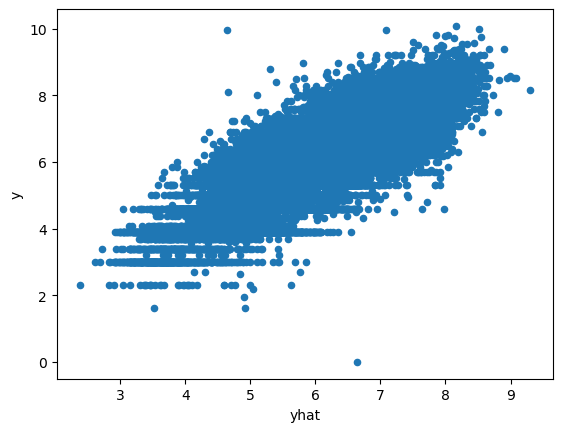

In [53]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')
df

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Here we use a plot to visualize *Frisch elasticities*, with confidence intervals. Higher values means that the good is more elastic in response to changes in income.


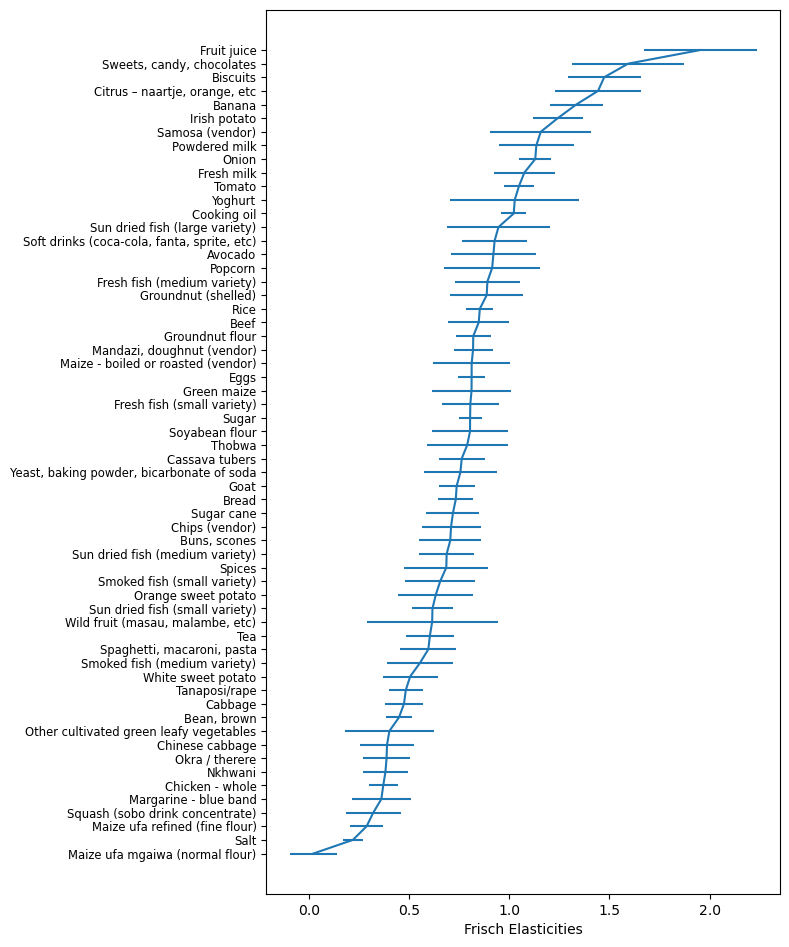

In [54]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [10]:
result.get_beta()

j
Avocado                                        0.921294
Banana                                         1.334759
Bean, brown                                    0.450482
Beef                                           0.848220
Biscuits                                       1.473836
Bread                                          0.733515
Buns, scones                                   0.706256
Cabbage                                        0.475333
Cassava tubers                                 0.763293
Chicken - whole                                0.371848
Chinese cabbage                                0.390740
Chips (vendor)                                 0.710060
Citrus – naartje, orange, etc                  1.443437
Cooking oil                                    1.022874
Eggs                                           0.812722
Fresh fish (medium variety)                    0.891365
Fresh fish (small variety)                     0.806225
Fresh milk                                    

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [11]:
result.get_gamma()

k                                                boys     women     girls  \
j                                                                           
Avocado                                      0.082647 -0.090723  0.144770   
Banana                                       0.104810  0.073983  0.058964   
Bean, brown                                  0.014614  0.006570  0.030126   
Beef                                         0.065358 -0.045032  0.140557   
Biscuits                                     0.089625 -0.111137  0.202924   
Bread                                        0.027696 -0.026787  0.023645   
Buns, scones                                 0.029256 -0.008974  0.005267   
Cabbage                                      0.022490 -0.004530  0.036722   
Cassava tubers                               0.061342 -0.013895  0.029636   
Chicken - whole                              0.035530 -0.012320  0.024621   
Chinese cabbage                              0.141620  0.071405  0.008218   
Chips (vendor)                               0.061273 -0.007917  0.028301   
Citrus – naartje, orange, etc                0.040468  0.093515 -0.009104   
Cooking oil                                  0.059268  0.043645 -0.002172   
Eggs                                         0.088599  0.010881  0.070498   
Fresh fish (medium variety)                  0.100174  0.077572  0.165834   
Fresh fish (small variety)                  -0.047619  0.042162  0.033875   
Fresh milk                                   0.087583  0.039708  0.057892   
Fruit juice                                 -0.028096  0.158189  0.033331   
Goat                                        -0.023479  0.029980  0.073611   
Green maize                                  0.075277  0.028226 -0.017898   
Groundnut (shelled)                         -0.015881  0.055839  0.072621   
Groundnut flour                              0.038800  0.018694  0.039306   
Irish potato                                 0.028363  0.006356  0.050271   
Maize - boiled or roasted (vendor)           0.120867 -0.051437  0.089272   
Maize ufa mgaiwa (normal flour)              0.107053  0.069546  0.062571   
Maize ufa refined (fine flour)              -0.011333  0.024010  0.024964   
Mandazi, doughnut (vendor)                   0.067646  0.006609  0.036137   
Margarine - blue band                        0.114900 -0.026741  0.113943   
Nkhwani                                      0.093754  0.039166  0.063073   
Okra / therere                               0.096819 -0.033845  0.137520   
Onion                                        0.092579  0.047315 -0.014146   
Orange sweet potato                         -0.037321 -0.042130  0.085967   
Other cultivated green leafy vegetables      0.059336  0.133983  0.028136   
Popcorn                                      0.082701  0.053081 -0.128037   
Powdered milk                                0.132411 -0.174683  0.194177   
Rice                                         0.126652  0.044728  0.055596   
Salt                                         0.054299  0.043423  0.009846   
Samosa (vendor)                              0.062832  0.123818 -0.000856   
Smoked fish (medium variety)                 0.124890  0.058522  0.020379   
Smoked fish (small variety)                  0.099372  0.006744  0.044016   
Soft drinks (coca-cola, fanta, sprite, etc)  0.059093  0.112850  0.020550   
Soyabean flour                               0.113758 -0.002154  0.068696   
Spaghetti, macaroni, pasta                  -0.094268 -0.113272  0.101429   
Spices                                       0.188969  0.043296  0.043988   
Squash (sobo drink concentrate)             -0.036279 -0.071180  0.117277   
Sugar                                        0.084703  0.089000  0.060130   
Sugar cane                                   0.016119 -0.029292  0.008103   
Sun dried fish (large variety)               0.132348  0.016921  0.149520   
Sun dried fish (medium variety)              0.053031  0.036538 -0.024181

##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

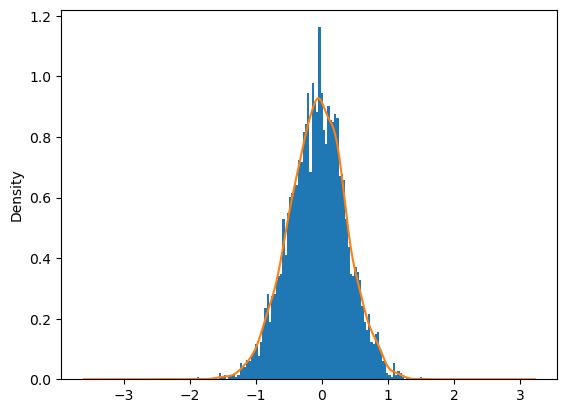

In [12]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [13]:
# Save the regression result
result.to_pickle('senegal_estimates.rgsn')

You can subsequently load this using



In [14]:

result = cfe.regression.read_pickle('senegal_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [15]:


# Get predicted expenditures
xhat = result.predicted_expenditures()

# Total food expenditures per household (i, t, m)
xbar = xhat.groupby(['i', 't', 'm']).sum()

# Reference budget: median household's budget
xref = xbar.quantile(0.5)  # 50th percentile

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [16]:
# Step 1: Average prices across markets
pbar = p.mean(axis=1)  # average over markets (axis=1)

# Step 2: Keep only goods that exist in both price data and estimated betas
estimated_goods = result.beta.index             # goods estimated by the model
available_goods = pbar.index                    # goods for which we have price data
common_goods = estimated_goods.intersection(available_goods)  # safe intersection
pbar = pbar.loc[common_goods]

# Step 3: Replace any missing values with 1 (for stability in simulations)
pbar = pbar.replace(np.nan, 1)

def my_prices(p0, j, p=pbar):
    """
    Change price of j-th good to p0, holding other prices fixed.
    
    Parameters:
    p0: new price to set
    j:  name of the good (string)
    p:  reference price vector (default: pbar)
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [17]:
pbar.head()

j
Avocado         245.233026
Banana          412.696593
Bean, brown     980.704749
Beef           2549.298987
Biscuits       1111.150515
dtype: float64

Available goods: ['Avocado', 'Banana', 'Bean, brown', 'Beef', 'Biscuits', 'Bread', 'Buns, scones', 'Cabbage', 'Cassava tubers', 'Chicken - whole', 'Chinese cabbage', 'Chips (vendor)', 'Citrus – naartje, orange, etc', 'Cooking oil', 'Eggs', 'Fresh fish (medium variety)', 'Fresh fish (small variety)', 'Fresh milk', 'Fruit juice', 'Goat', 'Green maize', 'Groundnut (shelled)', 'Groundnut flour', 'Irish potato', 'Maize - boiled or roasted (vendor)', 'Maize ufa mgaiwa (normal flour)', 'Maize ufa refined (fine flour)', 'Mandazi, doughnut (vendor)', 'Margarine - blue band', 'Nkhwani', 'Okra / therere', 'Onion', 'Orange sweet potato', 'Other cultivated green leafy vegetables', 'Popcorn', 'Powdered milk', 'Rice', 'Salt', 'Samosa (vendor)', 'Smoked fish (medium variety)', 'Smoked fish (small variety)', 'Soft drinks (coca-cola, fanta, sprite, etc)', 'Soyabean flour', 'Spaghetti, macaroni, pasta', 'Spices', 'Squash (sobo drink concentrate)', 'Sugar', 'Sugar cane', 'Sun dried fish (large variety)', 

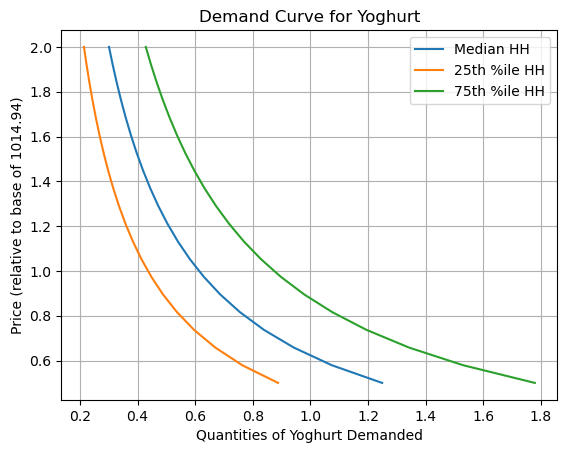

In [18]:
import matplotlib.pyplot as plt


#Step 1: Get average price per good from the data
pbar_full = p.mean(axis=1)  # Average across markets

#Step 2: Reindex to match the order of goods used in the regression model
goods = result.beta.index  # This is the correct good order expected by the model
pbar = pbar_full.reindex(goods)  # Align price vector to match model order

#Step 3: Fill any missing prices with 1 (to avoid errors)
pbar = pbar.fillna(1)

#Step 4: Choose a good from the list (make sure it's in result.beta.index)
print("Available goods:", list(pbar.index))
use = 'Yoghurt'  # Replace with another valid good if needed

#Step 5: Define a safe price-change function
def my_prices(p0, j, p=pbar):
    p = p.copy()
    p.loc[j] = p0
    return p

#Step 6: Plot demand curve
scale = np.linspace(0.5, 2, 20)

#Demand at median budget
plt.plot(
    [result.demands(xref, my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='Median HH'
)

#25th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.25), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='25th %ile HH'
)

#75th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.75), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='75th %ile HH'
)

#Step 7: Final plot formatting
plt.xlabel(f"Quantities of {use} Demanded")
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.title(f"Demand Curve for {use}")
plt.legend()
plt.grid(True)
plt.show()

##### Engel Curves



Engel curves trace out how demand changes with budget:



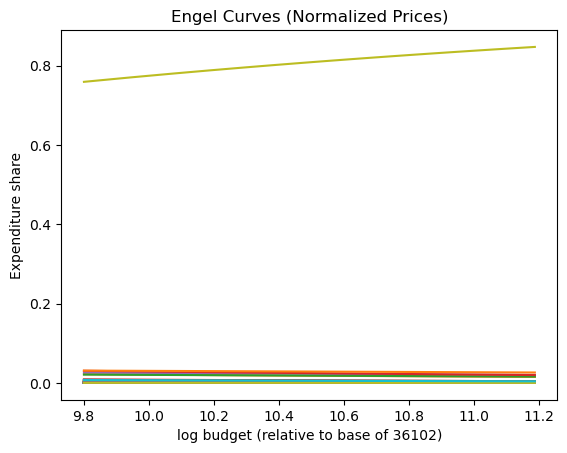

In [19]:
# Step 1: Normalize reference prices so their average is 1
pbar_normalized = pbar / pbar.mean()

# Step 2: Recalculate Engel curves with normalized pbar
fig, ax = plt.subplots()

ax.plot(
    np.log(scale * xref),
    [result.expenditures(s * xref, pbar_normalized) / (s * xref) for s in scale]
)

ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Normalized Prices)")

plt.show()

In [20]:
# Expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref
shares.sort_values(ascending=False).head(10)

j
Chicken - whole                    0.101009
Beef                               0.057202
Goat                               0.050539
Margarine - blue band              0.044620
Smoked fish (medium variety)       0.043144
Sun dried fish (medium variety)    0.032975
Sun dried fish (small variety)     0.029642
Squash (sobo drink concentrate)    0.029224
Smoked fish (small variety)        0.027243
Fresh fish (medium variety)        0.025916
Name: quantities, dtype: float64

Engel Curve of Top 5 Non-Dominant Goods (exclude Huile de soja / végétale):

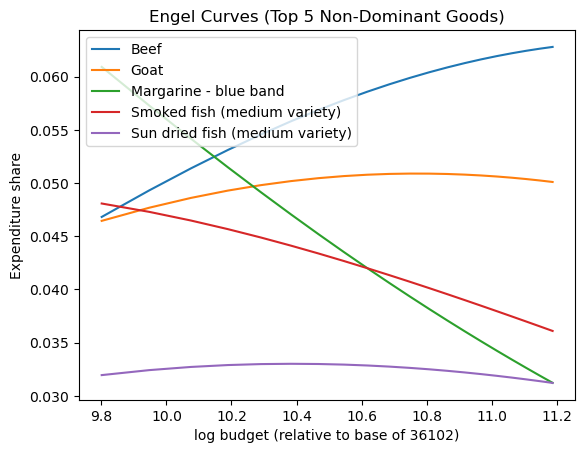

In [21]:
import consumerdemands._core as core

# Loosen solver tolerance to avoid convergence issues
core.default_solver_tolerance = 1e-8

# Step 1: Define scale
scale = np.linspace(0.5, 2, 20)

# Step 2: Calculate expenditure shares
shares = result.expenditures(xref, pbar) / xref
dominant_good = shares.sort_values(ascending=False).index[0]
top_goods = shares.drop(dominant_good).sort_values(ascending=False).head(5).index

# Step 3: Compute Engel curves using full price vector
fig, ax = plt.subplots()

for g in top_goods:
    share_curve = []
    for s in scale:
        try:
            demands = result.demands(s * xref, pbar)
            share = demands[g] * pbar[g] / (s * xref)
            share_curve.append(share)
        except Exception as e:
            print(f"Skipped {g} at scale {s} due to error: {e}")
            share_curve.append(np.nan)
    
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 4: Plot formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Top 5 Non-Dominant Goods)")
ax.legend()
plt.show()

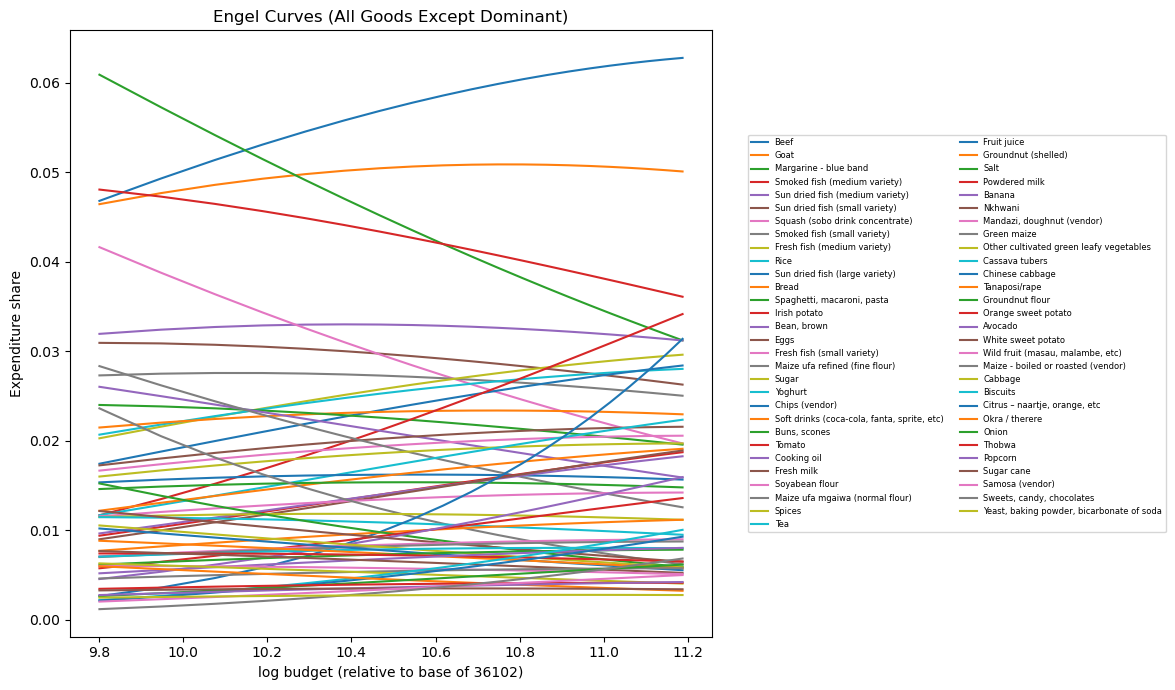

In [22]:
# Step 1: Compute expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref

# Step 2: Drop dominant good (the one with the highest share)
shares_no_dominant = shares.sort_values(ascending=False).iloc[1:]
goods_to_plot = shares_no_dominant.index

# Step 3: Budget scaling range
scale = np.linspace(0.5, 2, 20)

# Step 4: Plot Engel curves
fig, ax = plt.subplots(figsize=(12, 7))

for g in goods_to_plot:
    share_curve = [
        result.demands(s * xref, pbar)[g] * pbar[g] / (s * xref)
        for s in scale
    ]
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 5: Labels, legend, formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (All Goods Except Dominant)")
ax.legend(fontsize=6, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.tight_layout()
plt.show()

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



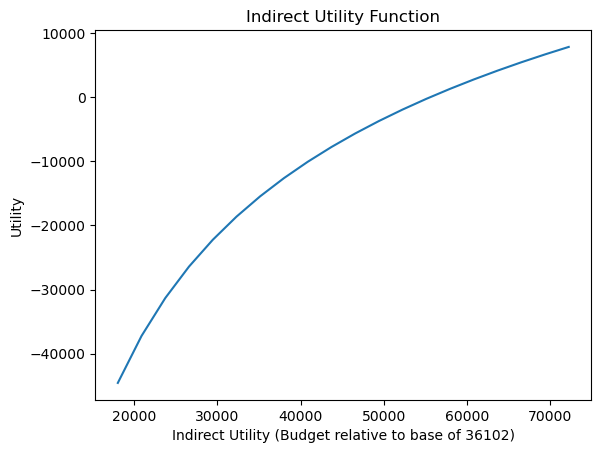

In [23]:
# Plot the indirect utility function over scaled budgets
fig, ax = plt.subplots()

# Compute utility values for different scaled budgets
utilities = [result.indirect_utility(s * xref, pbar) for s in scale]

# Plot
ax.plot(scale * xref, utilities)
ax.set_xlabel(f"Indirect Utility (Budget relative to base of {xref:.0f})")
ax.set_ylabel("Utility")
ax.set_title("Indirect Utility Function")
plt.show()

# Nutritional Analysis of Diet

In [24]:
fct = pd.read_csv("./Data/FCT.csv", index_col = 0)
fct.head()

k  Energy  Protein  Fiber  Folate  Calcium  \
j                                                                           
Avocado                   Avocat    1600     20.0   70.0     810      120   
Beans (dry)      Haricots (secs)    1700     98.0   60.0     500      580   
Beans (fresh)   Haricots (frais)    3470    214.0  160.0    5250     1130   
Beef                        Bœuf    2510    182.0    0.0      60       70   
Beef (roasted)       Bœuf (rôti)    2910    264.0    0.0      70       90   

                Carbohydrate  Iron  Niacin  Riboflavin  Thiamin  Vitamin A  \
j                                                                            
Avocado                 85.0   6.0   17.38        1.30     0.67         70   
Beans (dry)            325.0  30.0    7.00        1.20     3.40          0   
Beans (fresh)          626.0  51.0   11.74        2.12     7.13          0   
Beef                     0.0  19.0   31.50        1.60     0.90          0   
Beef (roasted)           0.0  27.0   37.20        2.20     0.90          0   

                Vitamin B-12  Vitamin B-6  Vitamin C  Zinc  
j                                                           
Avocado                  0.0         2.57        100   6.0  
Beans (dry)              0.0         2.15         10   8.0  
Beans (fresh)            0.0         4.74         63  23.0  
Beef                    28.9         3.80          0  37.0  
Beef (roasted)          24.7         3.40          0  60.0

In [56]:

# Get expenditures...
expend = pd.concat([expenditures_0405, expenditures_1011, expenditures_1617, expenditures_1920])
expend

j                              apple  avocado  banana  bean, brown  \
i            t       m                                               
10101002025  2004-05 North       NaN     10.0     NaN          NaN   
10101002051  2004-05 North       NaN      NaN     NaN          NaN   
10101002072  2004-05 North       NaN      5.0     5.0          NaN   
10101002079  2004-05 North       NaN     16.0    60.0          NaN   
10101002095  2004-05 North       NaN      NaN     NaN          NaN   
...                              ...      ...     ...          ...   
315538160177 2019-20 Southern    NaN      NaN     NaN          NaN   
315538160189 2019-20 Southern    NaN      NaN     NaN          NaN   
315538160190 2019-20 Southern    NaN      NaN     NaN          NaN   
315538160235 2019-20 Southern    NaN      NaN     NaN          NaN   
315538160239 2019-20 Southern    NaN      NaN     NaN          NaN   

j                              bean, white   beef  biscuits  \
i            t       m                                        
10101002025  2004-05 North             NaN  160.0       NaN   
10101002051  2004-05 North             NaN    NaN       NaN   
10101002072  2004-05 North             NaN    NaN       NaN   
10101002079  2004-05 North             NaN   60.0       NaN   
10101002095  2004-05 North             NaN    NaN       NaN   
...                                    ...    ...       ...   
315538160177 2019-20 Southern          NaN    NaN       NaN   
315538160189 2019-20 Southern          NaN    NaN       NaN   
315538160190 2019-20 Southern          NaN    NaN       NaN   
315538160235 2019-20 Southern          NaN    NaN       NaN   
315538160239 2019-20 Southern          NaN    NaN       NaN   

j                              bottled/ canned beer  bread  breakfast cereal  \
i            t       m                                                         
10101002025  2004-05 North                      NaN    NaN               NaN   
10101002051  2004-05 North                      NaN    NaN               NaN   
10101002072  2004-05 North                      NaN    NaN               NaN   
10101002079  2004-05 North                      NaN    NaN               NaN   
10101002095  2004-05 North                      NaN    NaN               NaN   
...                                             ...    ...               ...   
315538160177 2019-20 Southern                   NaN    NaN               NaN   
315538160189 2019-20 Southern                   NaN    NaN               NaN   
315538160190 2019-20 Southern                   NaN    NaN               NaN   
315538160235 2019-20 Southern                   NaN    NaN               NaN   
315538160239 2019-20 Southern                   NaN    NaN               NaN   

j                              ...  \
i            t       m         ...   
10101002025  2004-05 North     ...   
10101002051  2004-05 North     ...   
10101002072  2004-05 North     ...   
10101002079  2004-05 North     ...   
10101002095  2004-05 North     ...   
...                            ...   
315538160177 2019-20 Southern  ...   
315538160189 2019-20 Southern  ...   
315538160190 2019-20 Southern  ...   
315538160235 2019-20 Southern  ...   
315538160239 2019-20 Southern  ...   

j                              Maize ufa processed madeya (bran flour - processed)  \
i            t       m                                                               
10101002025  2004-05 North                                                   NaN     
10101002051  2004-05 North                                                   NaN     
10101002072  2004-05 North                                                   NaN     
10101002079  2004-05 North                                                   NaN     
10101002095  2004-05 North                                                   NaN     
...                                                                          ...     
315538160177 2019-20 Southern                

In [27]:

#result = cfe.Regression(y=np.log(expend.stack()),d=hhc)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Fruit juice                                    1.953511
Sweets, candy, chocolates                      1.593155
Biscuits                                       1.473836
Citrus – naartje, orange, etc                  1.443437
Banana                                         1.334759
Irish potato                                   1.242634
Samosa (vendor)                                1.157753
Powdered milk                                  1.135466
Onion                                          1.130243
Fresh milk                                     1.075878
Tomato                                         1.048691
Yoghurt                                        1.027837
Cooking oil                                    1.022874
Sun dried fish (large variety)                 0.946686
Soft drinks (coca-cola, fanta, sprite, etc)    0.927463
Avocado                                        0.921294
Popcorn                                        0.915088
Fresh fish (medium variety)                   

# Top 10 most consumed foods


In [59]:
import plotly.express as px
import matplotlib.pyplot as plt


def plot_top_foods_by_household(
    hhc,
    expend,
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None,
    top_n=10
):
    """Filters households by demographic range and plots top consumed foods by expenditure."""

    # Set multi-index if not already
    hhc.index.names = ['i', 't', 'm']
    expend.index.names = ['i', 't', 'm']
    hhc.index.names = ['i', 't', 'm']
    male_adult_cols   = ["M 19-30", "M 31-50", "M 51+"]
    female_adult_cols = ["F 19-30", "F 31-50", "F 51+"]
    kid_cols          = [
            "F 00-03", "M 00-03",
            "F 04-08", "M 04-08",
            "F 09-13", "M 09-13",
            "F 14-18", "M 14-18"
        ]
    

    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
    hhc = hhc.copy()
    hhc["male_adults"]   = hhc[male_adult_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_adult_cols].sum(axis=1)
    hhc["kids"]          = hhc[kid_cols].sum(axis=1)
    
    # 3) Build a Boolean mask based on the input constraints
    mask = True

    # male adults
    if max_males is None:
        mask &= (hhc["male_adults"] >= min_males)
    else:
        mask &= (hhc["male_adults"] >= min_males) & (hhc["male_adults"] <= max_males)
    
    # female adults
    if max_females is None:
        mask &= (hhc["female_adults"] >= min_females)
    else:
        mask &= (hhc["female_adults"] >= min_females) & (hhc["female_adults"] <= max_females)
    
    # kids
    if max_kids is None:
        mask &= (hhc["kids"] >= min_kids)
    else:
        mask &= (hhc["kids"] >= min_kids) & (hhc["kids"] <= max_kids)

    # 4) Filter the household composition
    hhc_filtered = hhc[mask]
    #common_idx = hhc_filtered.index.intersection(expend.index)
    #expend_filtered = expend.loc[common_idx]

    # Sum expenditures per food
    #top_expenditures = expend_filtered.sum().sort_values(ascending=False).head(top_n)
    top_expenditures = expend.sum().sort_values(ascending=False).head(top_n)
    # Plot
    plt.figure(figsize=(10, 6))
    top_expenditures.sort_values().plot(kind='barh')
    plt.title(f"Top {top_n} Food Items by Expenditure for Selected Household Type")
    plt.xlabel("Total Expenditure")
    plt.tight_layout()
    plt.show()

    return top_expenditures



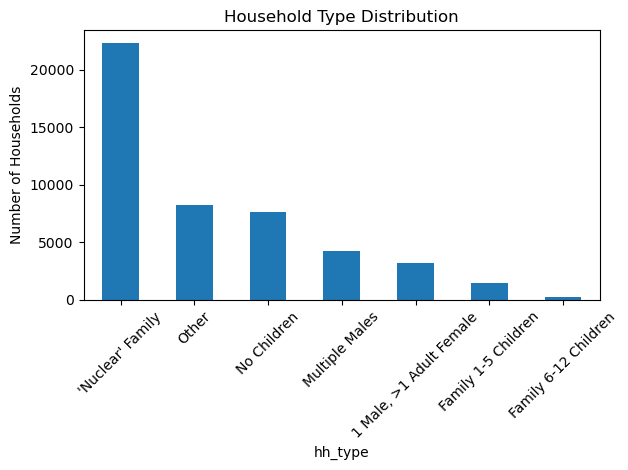

In [60]:

    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
hhc1 = hhc.copy()

def classify_household(row):
    if row["men"] == 1 and row["women"] == 1 and row["girls"]+row['boys'] > 0:
        return "'Nuclear' Family"
    elif row["men"] == 1 and row["women"] > 1 and row["girls"]+row['boys'] > 0:
        return "1 Male, >1 Adult Female"
    elif row["men"] > 1 and row["women"] <= 1 and row["girls"]+row['boys'] > 0:
        return "Multiple Males"
    elif row["men"] > 1 and row["women"] >1 and row["girls"]+row['boys'] > 1 and row["girls"]+row['boys'] <= 5:
        return "Family 1-5 Children"
    elif row["men"] > 1 and row["women"] >1 and row["girls"]+row['boys'] > 5 and row["girls"]+row['boys'] <= 12:
        return "Family 6-12 Children"
    elif row["men"] >= 0 and row["women"] >= 0 and row["girls"]+row['boys'] == 0:
        return "No Children"
    else:
        return "Other"
hhc["hh_type"] = hhc.apply(classify_household, axis=1)
# Plot household type distribution
import matplotlib.pyplot as plt
hhc["hh_type"].value_counts().plot(kind="bar", title="Household Type Distribution")
plt.ylabel("Number of Households")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [81]:
hhc = hhc.set_index(["i", "t", "m"])
hhc.index.names = ["i", "t", "m"]
hhc

boys  women  girls  men  M 00-03  F 00-03  \
i            t       m                                                     
10101002025  2004-05 North        3      1      2    1        1        1   
10101002051  2004-05 North        0      1      1    1        0        1   
10101002072  2004-05 North        3      1      1    1        1        1   
10101002079  2004-05 North        1      1      3    1        0        2   
10101002095  2004-05 North        2      1      2    1        0        0   
...                             ...    ...    ...  ...      ...      ...   
315538160177 2019-20 Southern     1      1      0    1        1        0   
315538160189 2019-20 Southern     0      1      1    1        0        0   
315538160190 2019-20 Southern     0      0      0    1        0        0   
315538160235 2019-20 Southern     1      1      0    1        0        0   
315538160239 2019-20 Southern     0      0      0    1        0        0   

                               M 04-08  F 04-08  M 09-13  F 09-13  M 14-18  \
i            t       m                                                       
10101002025  2004-05 North           0        1        1        0        1   
10101002051  2004-05 North           0        0        0        0        0   
10101002072  2004-05 North           1        0        0        0        1   
10101002079  2004-05 North           1        1        0        0        0   
10101002095  2004-05 North           0        2        2        0        0   
...                                ...      ...      ...      ...      ...   
315538160177 2019-20 Southern        0        0        0        0        0   
315538160189 2019-20 Southern        0        1        0        0        0   
315538160190 2019-20 Southern        0        0        0        0        0   
315538160235 2019-20 Southern        0        0        1        0        0   
315538160239 2019-20 Southern        0        0        0        0        0   

                               F 14-18  M 19-30  F 19-30  M 31-50  F 31-50  \
i            t       m                                                       
10101002025  2004-05 North           0        0        0        1        1   
10101002051  2004-05 North           1        1        0        0        0   
10101002072  2004-05 North           0        0        1        1        0   
10101002079  2004-05 North           0        0        0        1        1   
10101002095  2004-05 North           0        1        1        0        0   
...                                ...      ...      ...      ...      ...   
315538160177 2019-20 Southern        0        1        1        0        0   
315538160189 2019-20 Southern        0        1        1        0        0   
315538160190 2019-20 Southern        0        0        0        1        0   
315538160235 2019-20 Southern        0        1        1        0        0   
315538160239 2019-20 Southern        0        1        0        0        0   

                               M 51+  F 51+  log HSize  
i            t       m                                  
10101002025  2004-05 North         0      0   1.945910  
10101002051  2004-05 North         0      0   1.098612  
10101002072  2004-05 North         0      0   1.791759  
10101002079  2004-05 North         0      0   1.791759  
10101002095  2004-05 North         0      0   1.791759  
...                              ...    ...        ...  
315538160177 2019-20 Southern      0      0   1.098612  
315538160189 2019-20 Southern      0      0   1.098612  
315538160190 2019-20 Southern      0      0   0.000000  
315538160235 2019-20 Southern      0      0   1.098612  
315538160239 2019-20 Southern      0      0   0.000000  

[47432 rows x 19 columns]

In [82]:
nutrient_ratio = pd.concat([nutritional_ratio_0405, nutritional_ratio_1011, nutritional_ratio_1617, nutritional_ratio_1920])
nutrient_ratio.index.names = ["i","t","m"]
nutrient_ratio

n                                Energy   Protein     Fiber    Folate  \
i            t       m                                                  
10101002246  2004-05 North     0.317226  0.344176  0.122321  0.210407   
10101003013  2004-05 North     0.213677  0.265355  0.081655  0.143809   
10101003017  2004-05 North     0.693621  0.829830  0.170831  0.331070   
10101003020  2004-05 North     1.092045  0.965945  0.301179  0.524460   
10101003062  2004-05 North     0.325022  0.368357  0.100165  0.177115   
...                                 ...       ...       ...       ...   
315538160174 2019-20 Southern  0.334155  0.283777  0.182694  0.319421   
315538160177 2019-20 Southern  0.430094  0.385015  0.189314  0.380507   
315538160189 2019-20 Southern  0.455647  0.395912  0.215804  0.414169   
315538160235 2019-20 Southern  0.581541  0.483352  0.248231  0.505550   
315538160239 2019-20 Southern  0.646977  0.553003  0.286292  0.625040   

n                               Calcium  Carbohydrate      Iron    Niacin  \
i            t       m                                                      
10101002246  2004-05 North     0.054597      0.276591  0.165516  0.177329   
10101003013  2004-05 North     0.030084      0.181100  0.119858  0.124251   
10101003017  2004-05 North     0.071831      0.351300  0.298986  0.350356   
10101003020  2004-05 North     0.162772      0.758622  0.470854  0.507525   
10101003062  2004-05 North     0.037760      0.227791  0.142395  0.156775   
...                                 ...           ...       ...       ...   
315538160174 2019-20 Southern  0.062010      0.458269  0.238081  0.287589   
315538160177 2019-20 Southern  0.102411      0.602988  0.315416  0.387481   
315538160189 2019-20 Southern  0.103150      0.679128  0.320098  0.408563   
315538160235 2019-20 Southern  0.124613      0.932511  0.463476  0.500034   
315538160239 2019-20 Southern  0.186693      1.230752  0.905138  0.604233   

n                              Riboflavin   Thiamin  Vitamin A  Vitamin B-12  \
i            t       m                                                         
10101002246  2004-05 North       0.367091  0.159299   0.106872      0.737308   
10101003013  2004-05 North       0.261348  0.112752   0.075495      0.550083   
10101003017  2004-05 North       0.681877  0.302770   0.199624      1.774968   
10101003020  2004-05 North       0.998185  0.456314   0.284456      2.246979   
10101003062  2004-05 North       0.349439  0.142809   0.105809      0.784125   
...                                   ...       ...        ...           ...   
315538160174 2019-20 Southern    0.349489  0.281105   0.037960      0.443133   
315538160177 2019-20 Southern    0.440414  0.366573   0.046062      0.702537   
315538160189 2019-20 Southern    0.475594  0.395870   0.048812      0.697337   
315538160235 2019-20 Southern    0.592015  0.490564   0.061043      0.872212   
315538160239 2019-20 Southern    0.685709  0.594543   0.067980      1.170509   

n                              Vitamin B-6  Vitamin C      Zinc  
i            t       m                                           
10101002246  2004-05 North        0.288041   0.069373  0.195434  
10101003013  2004-05 North        0.208752   0.052833  0.131278  
10101003017  2004-05 North        0.610397   0.124745  0.369032  
10101003020  2004-05 North        0.825002   0.155388  0.520011  
10101003062  2004-05 North        0.292547   0.068301  0.162569  
...                                    ...        ...       ...  
315538160174 2019-20 Southern     0.267485   0.098599  0.204272  
315538160177 2019-20 Southern     0.335400   0.088687  0.317378  
315538160189 2019-20 Southern     0.361766   0.100828  0.313163  
315538160235 2019-20 Southern     0.423137   0.114263  0.377833  
315538160239 2019-20 Southern     0.547370   0.118619  0.441951  

[13382 rows x 15 columns]

In [83]:
def filter_households(
    hhc,              # The household composition DataFrame (indexed by i,t,m)
    nutrient_ratio,   # The nutrient outcomes DataFrame (indexed by i,t,m)
    xhat,
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None
):
    """
    Return the rows (households) whose composition fits the given
    # of adult males, adult females, and children,
    along with their corresponding nutrient outcomes.
    Both DataFrames must be MultiIndexed by (i, t, m).
    """

    # 1) Identify which columns correspond to kids vs adult males/females
    male_adult_cols   = ["M 19-30", "M 31-50", "M 51+"]
    female_adult_cols = ["F 19-30", "F 31-50", "F 51+"]
    kid_cols          = [
        "F 00-03", "M 00-03",
        "F 04-08", "M 04-08",
        "F 09-13", "M 09-13",
        "F 14-18", "M 14-18"
    ]
    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
    hhc = hhc.copy()
    hhc["male_adults"]   = hhc[male_adult_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_adult_cols].sum(axis=1)
    hhc["kids"]          = hhc[kid_cols].sum(axis=1)

    # 3) Build a Boolean mask based on the input constraints
    mask = True

    # male adults
    if max_males is None:
        mask &= (hhc["male_adults"] >= min_males)
    else:
        mask &= (hhc["male_adults"] >= min_males) & (hhc["male_adults"] <= max_males)
    
    # female adults
    if max_females is None:
        mask &= (hhc["female_adults"] >= min_females)
    else:
        mask &= (hhc["female_adults"] >= min_females) & (hhc["female_adults"] <= max_females)
    
    # kids
    if max_kids is None:
        mask &= (hhc["kids"] >= min_kids)
    else:
        mask &= (hhc["kids"] >= min_kids) & (hhc["kids"] <= max_kids)

    # 4) Filter the household composition
    hhc_filtered = hhc[mask]
   
    
    # 5) Intersection with nutrient_ratio's index
    #    so we only keep households that exist in BOTH data frames.
    common_idx = hhc_filtered.index.intersection(nutrient_ratio.index)
    hhc_filtered = hhc_filtered.loc[common_idx]
    nutrient_filtered = nutrient_ratio.loc[common_idx]

    # also filter out expenditures
    com_idx = hhc_filtered.index.intersection(xhat.unstack('j').index)
    house_expend = xhat.unstack('j')
    house_expend = house_expend.loc[com_idx]
    house_expend['total expenditures'] = house_expend[:].sum(axis=1)
    expenditures_filtered = house_expend
   
    return hhc_filtered, nutrient_filtered, expenditures_filtered


# Ensure both DataFrames are set to (i, t, m) as their index
hhc.index.names = ["i","t","m"]
nutrient_ratio = pd.concat([nutritional_ratio_0405, nutritional_ratio_1011, nutritional_ratio_1617, nutritional_ratio_1920])
nutrient_ratio.index.names = ["i","t","m"]


In [84]:
hhc_filtered, nutr_filt, expenditures_filtered = filter_households(
    hhc,              # The household composition DataFrame (indexed by i,t,m)
    nutrient_ratio,   # The nutrient outcomes DataFrame (indexed by i,t,m)
    xhat,
    min_males=0, max_males=100,
    min_females=0, max_females=100,
    min_kids=0, max_kids=100
)

hhc_filtered



boys  women  girls  men  M 00-03  F 00-03  \
i            t       m                                                     
10101002246  2004-05 North        1      1      0    1        1        0   
10101003013  2004-05 North        0      1      4    1        0        1   
10101003017  2004-05 North        1      1      4    1        0        2   
10101003020  2004-05 North        0      1      0    1        0        0   
10101003062  2004-05 North        2      1      5    2        0        2   
...                             ...    ...    ...  ...      ...      ...   
315538160174 2019-20 Southern     1      1      3    1        0        0   
315538160177 2019-20 Southern     1      1      0    1        1        0   
315538160189 2019-20 Southern     0      1      1    1        0        0   
315538160235 2019-20 Southern     1      1      0    1        0        0   
315538160239 2019-20 Southern     0      0      0    1        0        0   

                               M 04-08  F 04-08  M 09-13  F 09-13  ...  \
i            t       m                                             ...   
10101002246  2004-05 North           0        0        0        0  ...   
10101003013  2004-05 North           0        1        0        2  ...   
10101003017  2004-05 North           0        1        1        1  ...   
10101003020  2004-05 North           0        0        0        0  ...   
10101003062  2004-05 North           0        2        1        0  ...   
...                                ...      ...      ...      ...  ...   
315538160174 2019-20 Southern        1        1        0        2  ...   
315538160177 2019-20 Southern        0        0        0        0  ...   
315538160189 2019-20 Southern        0        1        0        0  ...   
315538160235 2019-20 Southern        0        0        1        0  ...   
315538160239 2019-20 Southern        0        0        0        0  ...   

                               M 19-30  F 19-30  M 31-50  F 31-50  M 51+  \
i            t       m                                                     
10101002246  2004-05 North           0        1        1        0      0   
10101003013  2004-05 North           0        1        1        0      0   
10101003017  2004-05 North           0        0        1        1      0   
10101003020  2004-05 North           0        1        1        0      0   
10101003062  2004-05 North           0        0        1        1      0   
...                                ...      ...      ...      ...    ...   
315538160174 2019-20 Southern        0        1        1        0      0   
315538160177 2019-20 Southern        1        1        0        0      0   
315538160189 2019-20 Southern        1        1        0        0      0   
315538160235 2019-20 Southern        1        1        0        0      0   
315538160239 2019-20 Southern        1        0        0        0      0   

                               F 51+  log HSize  male_adults  female_adults  \
i            t       m                                                        
10101002246  2004-05 North         0   1.098612            1              1   
10101003013  2004-05 North         0   1.791759            1              1   
10101003017  2004-05 North         0   1.945910            1              1   
10101003020  2004-05 North         0   0.693147            1              1   
10101003062  2004-05 North         0   2.302585            1              1   
...                              ...        ...          ...            ...   
315538160174 2019-20 Southern      0   1.791759            1              1   
315538160177 2019-20 Southern      0   1.098612            1              1   
315538160189 2019-20 Southern      0   1.098612            1              1   
315538160235 2019-20 Southern      0   1.098612            1              1   
315538160239 2019-20 Southern      0   0.000000            1              0   

                               kids  
i            t       m  

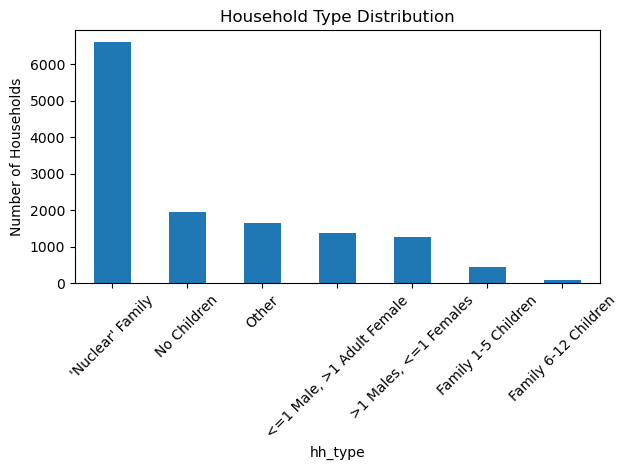

In [85]:

def classify_household(row):
    if row["male_adults"] == 1 and row["female_adults"] == 1 and row["kids"] > 0:
        return "'Nuclear' Family"
    elif row["male_adults"] <= 1 and row["female_adults"] > 1 and row["kids"] > 0 and row["kids"] <12:
        return "<=1 Male, >1 Adult Female"
    elif row["male_adults"] > 1 and row["female_adults"] <= 1 and row["kids"] > 0:
        return ">1 Males, <=1 Females"
    elif row["male_adults"] > 1 and row["female_adults"] >1 and row["kids"] > 1 and row["kids"] <= 5:
        return "Family 1-5 Children"
    elif row["male_adults"] > 1 and row["female_adults"] >1 and row["kids"] > 5 and row["kids"] <= 12:
        return "Family 6-12 Children"
    elif row["male_adults"] >= 0 and row["female_adults"] >= 0 and row["kids"] == 0:
        return "No Children"
    else:
        return "Other"
hhc_filtered["hh_type"] = hhc_filtered.apply(classify_household, axis=1)
# Plot household type distribution
import matplotlib.pyplot as plt
hhc_filtered["hh_type"].value_counts().plot(kind="bar", title="Household Type Distribution")
plt.ylabel("Number of Households")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [86]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_nutritional_adequacy_subplots_log(
    nut_df,
    adequacy_threshold=1.0,  # We'll draw a vertical line at log10(1.0) = 0
    bins=30,
    n_cols=3
):
    """
    Create subplots of histograms for each nutrient ratio, using log10 scale.
    We drop any rows where a nutrient ratio <= 0 to avoid log(0) or log(negative).
    
    Parameters:
    -----------
    nut_df : pd.DataFrame
        DataFrame of nutrient adequacy ratios, with each column a nutrient.
    adequacy_threshold : float
        We'll add a vertical line at log10(adequacy_threshold).
        e.g. if threshold=1.0, the line is at x=0. 
    bins : int
        Number of histogram bins.
    n_cols : int
        Number of columns of subplots (we auto-calc rows).
    """

    # 1) Filter out rows where any ratio <= 0
    #    (log10 is undefined for non-positive values)
    mask = (nut_df > 0).all(axis=1)
    df_pos = nut_df[mask].copy()
    
    # 2) Decide which columns to plot (skip any columns like 'n' if needed)
    plot_cols = [c for c in df_pos.columns if c not in ["n"]]
    
    # 3) Compute log10 for each plotted nutrient
    for col in plot_cols:
        df_pos["log10_" + col] = np.log10(df_pos[col])

    # 4) Create subplots: N rows x n_cols
    n_rows = math.ceil(len(plot_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharey=False)
    axes = axes.flatten()

    log_threshold = np.log10(adequacy_threshold)

    # 5) For each nutrient column, plot histogram of log10(ratio)
    for i, col in enumerate(plot_cols):
        ax = axes[i]
        sns.histplot(df_pos["log10_" + col], bins=bins, kde=False, ax=ax)
        ax.axvline(log_threshold, color="red", linestyle="--")
        ax.set_title(f"{col} (log scale)")
        ax.set_xlabel("log10(Adequacy Ratio)")
        ax.set_ylabel("Count of Households")

    # Hide extra subplot axes if the # of nutrients isn't a multiple of n_cols
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

     # 3) Compute fraction that meet/exceed threshold
    fraction_meeting = {}
    for col in nut_df.columns:
        if col in ("n",):  # skip non‐ratio columns
            continue
        # fraction of households with ratio >= threshold
        fraction_meeting[col] = (nut_df[col] >= adequacy_threshold).mean()

    # Turn this into a DataFrame for easy plotting
    frac_df = pd.DataFrame.from_dict(fraction_meeting, orient="index", columns=["Fraction >= Threshold"])
    frac_df = frac_df.sort_values("Fraction >= Threshold", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=frac_df["Fraction >= Threshold"], y=frac_df.index, orient="h")
    plt.title(f"Fraction of Households Meeting >= {adequacy_threshold} Ratio")
    plt.xlim(0, 1)  # fraction from 0 to 1
    for i, val in enumerate(frac_df["Fraction >= Threshold"]):
        plt.text(val + 0.01, i, f"{val:.1%}", va='center')  # label with percentage
    plt.tight_layout()
    plt.show()


# Household Characteristic - All Households, All Years

Average Weekly Food Expenditures: $38929.66 ($67.27 USD)


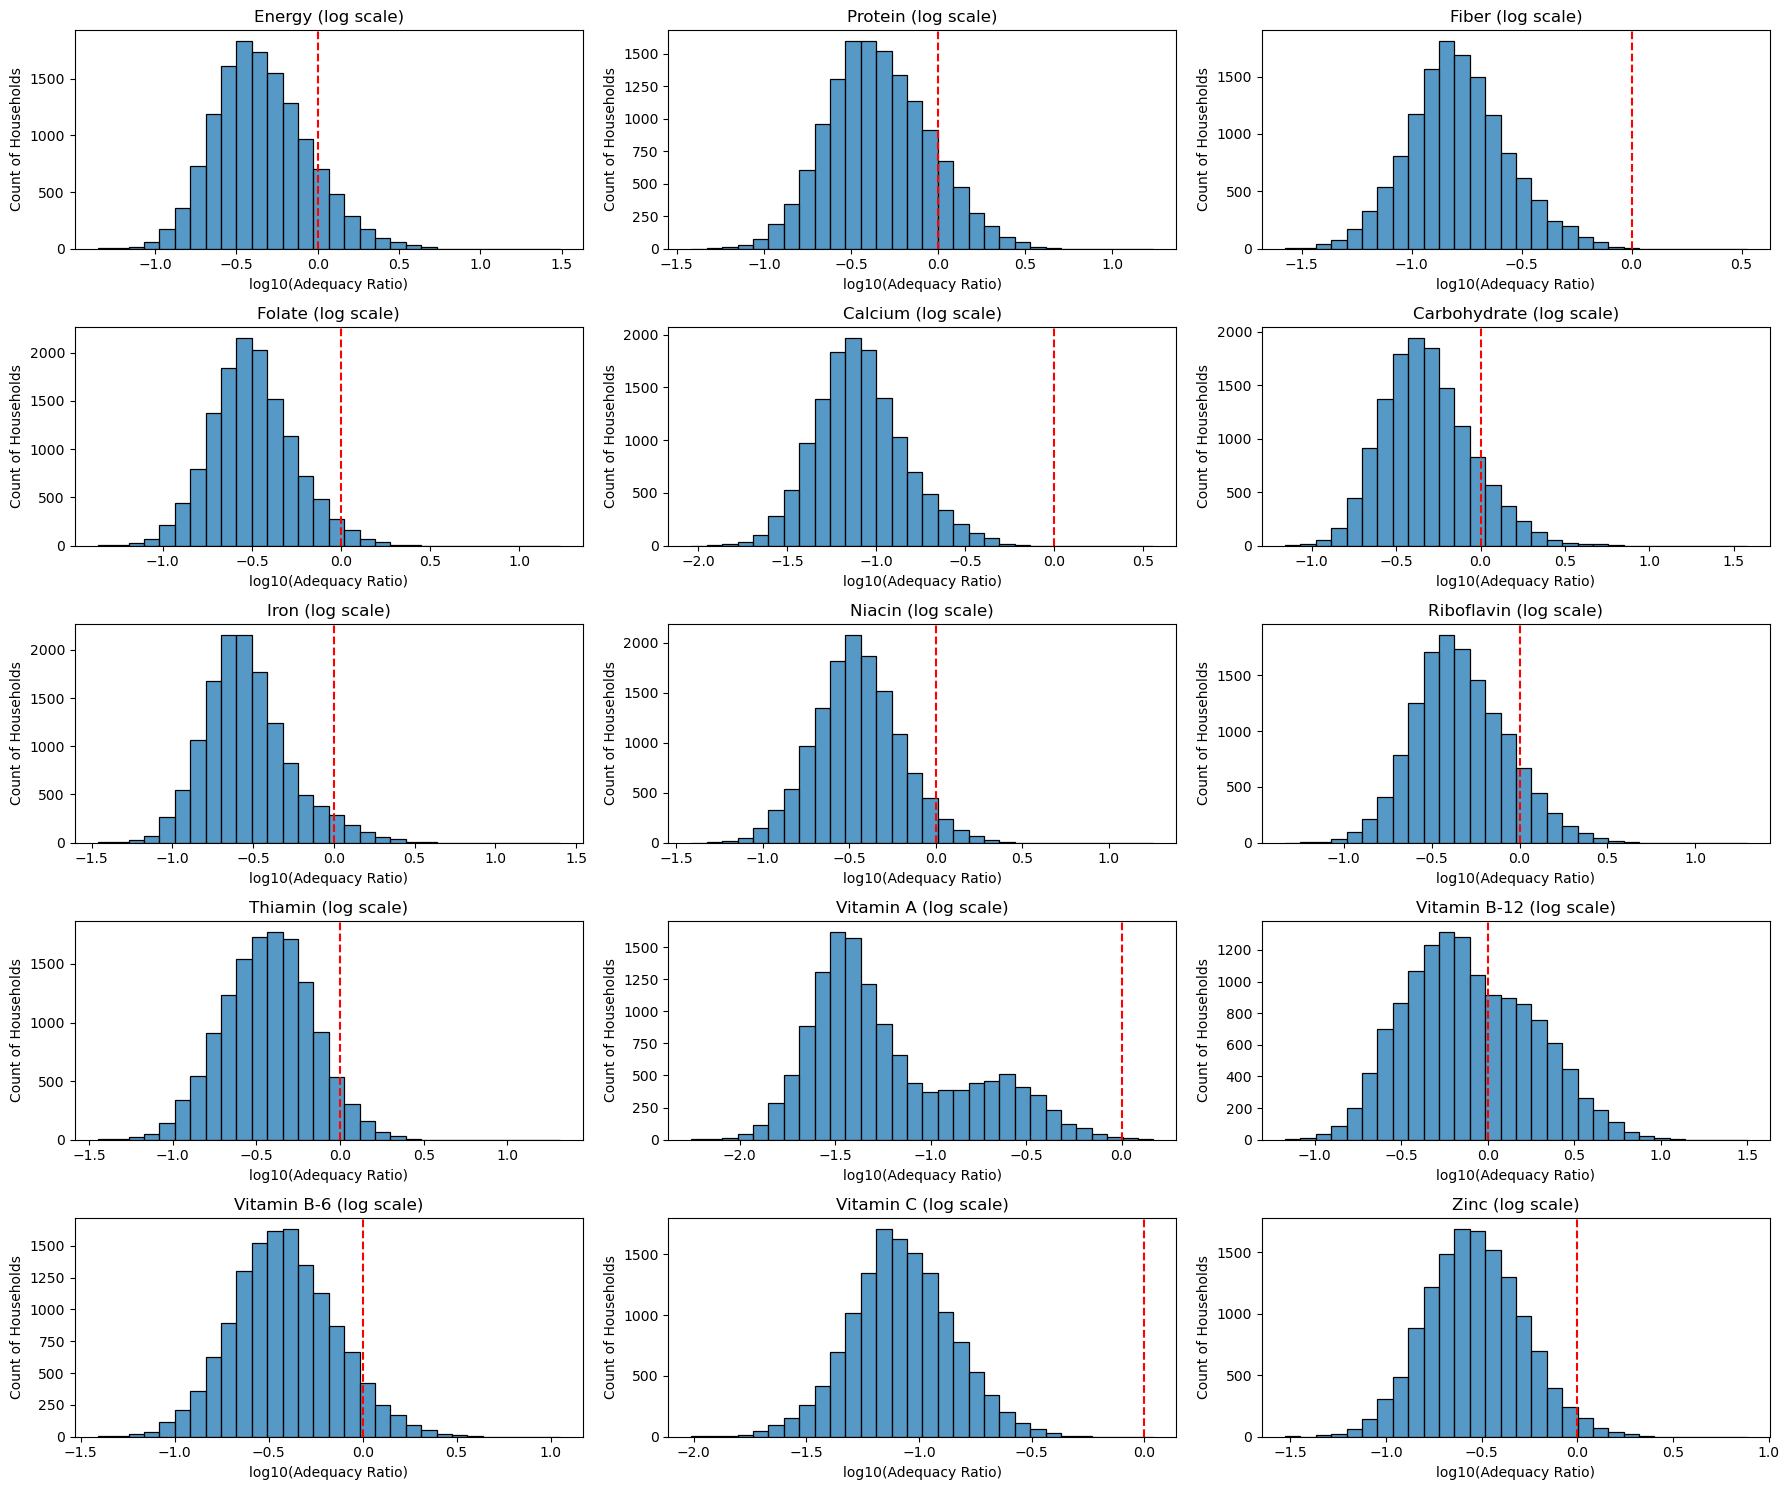

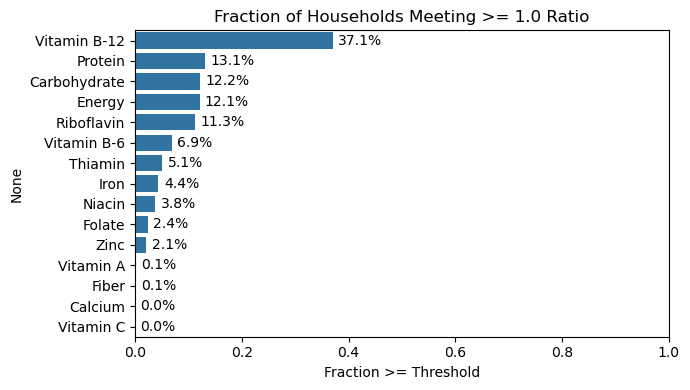

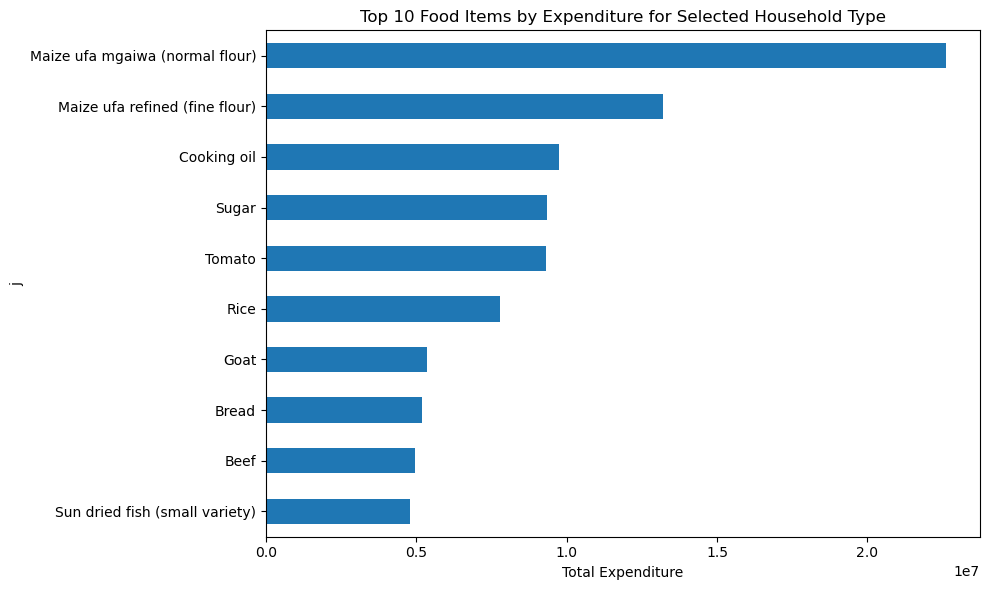

j
Maize ufa mgaiwa (normal flour)    22614580.0
Maize ufa refined (fine flour)     13213775.0
Cooking oil                         9755763.0
Sugar                               9331447.0
Tomato                              9306592.0
Rice                                7797477.0
Goat                                5357271.0
Bread                               5180935.0
Beef                                4957586.0
Sun dried fish (small variety)      4796095.0
dtype: float64

In [88]:
hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=0, max_males=100,       # e.g. 0 adult males
    min_females=0, max_females=100,   # e.g. 1–3 adult females
    min_kids=0, max_kids=100        # e.g. up to 2 kids
)
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')
analyze_nutritional_adequacy_subplots_log(nut_sub)
plot_top_foods_by_household(
    hhc,
    expend, 
    min_males=0, max_males=100,       # e.g. 0 adult males
    min_females=0, max_females=100,   # e.g. 1–3 adult females
    min_kids=0, max_kids=100)

In [89]:

print(f'# households:{hhc_sub.shape}')
#analyze_nutritional_adequacy(nut_sub)

# households:(13382, 22)


# households:(1378, 22)
Average Weekly Food Expenditures: $45344.02 ($78.35 USD)


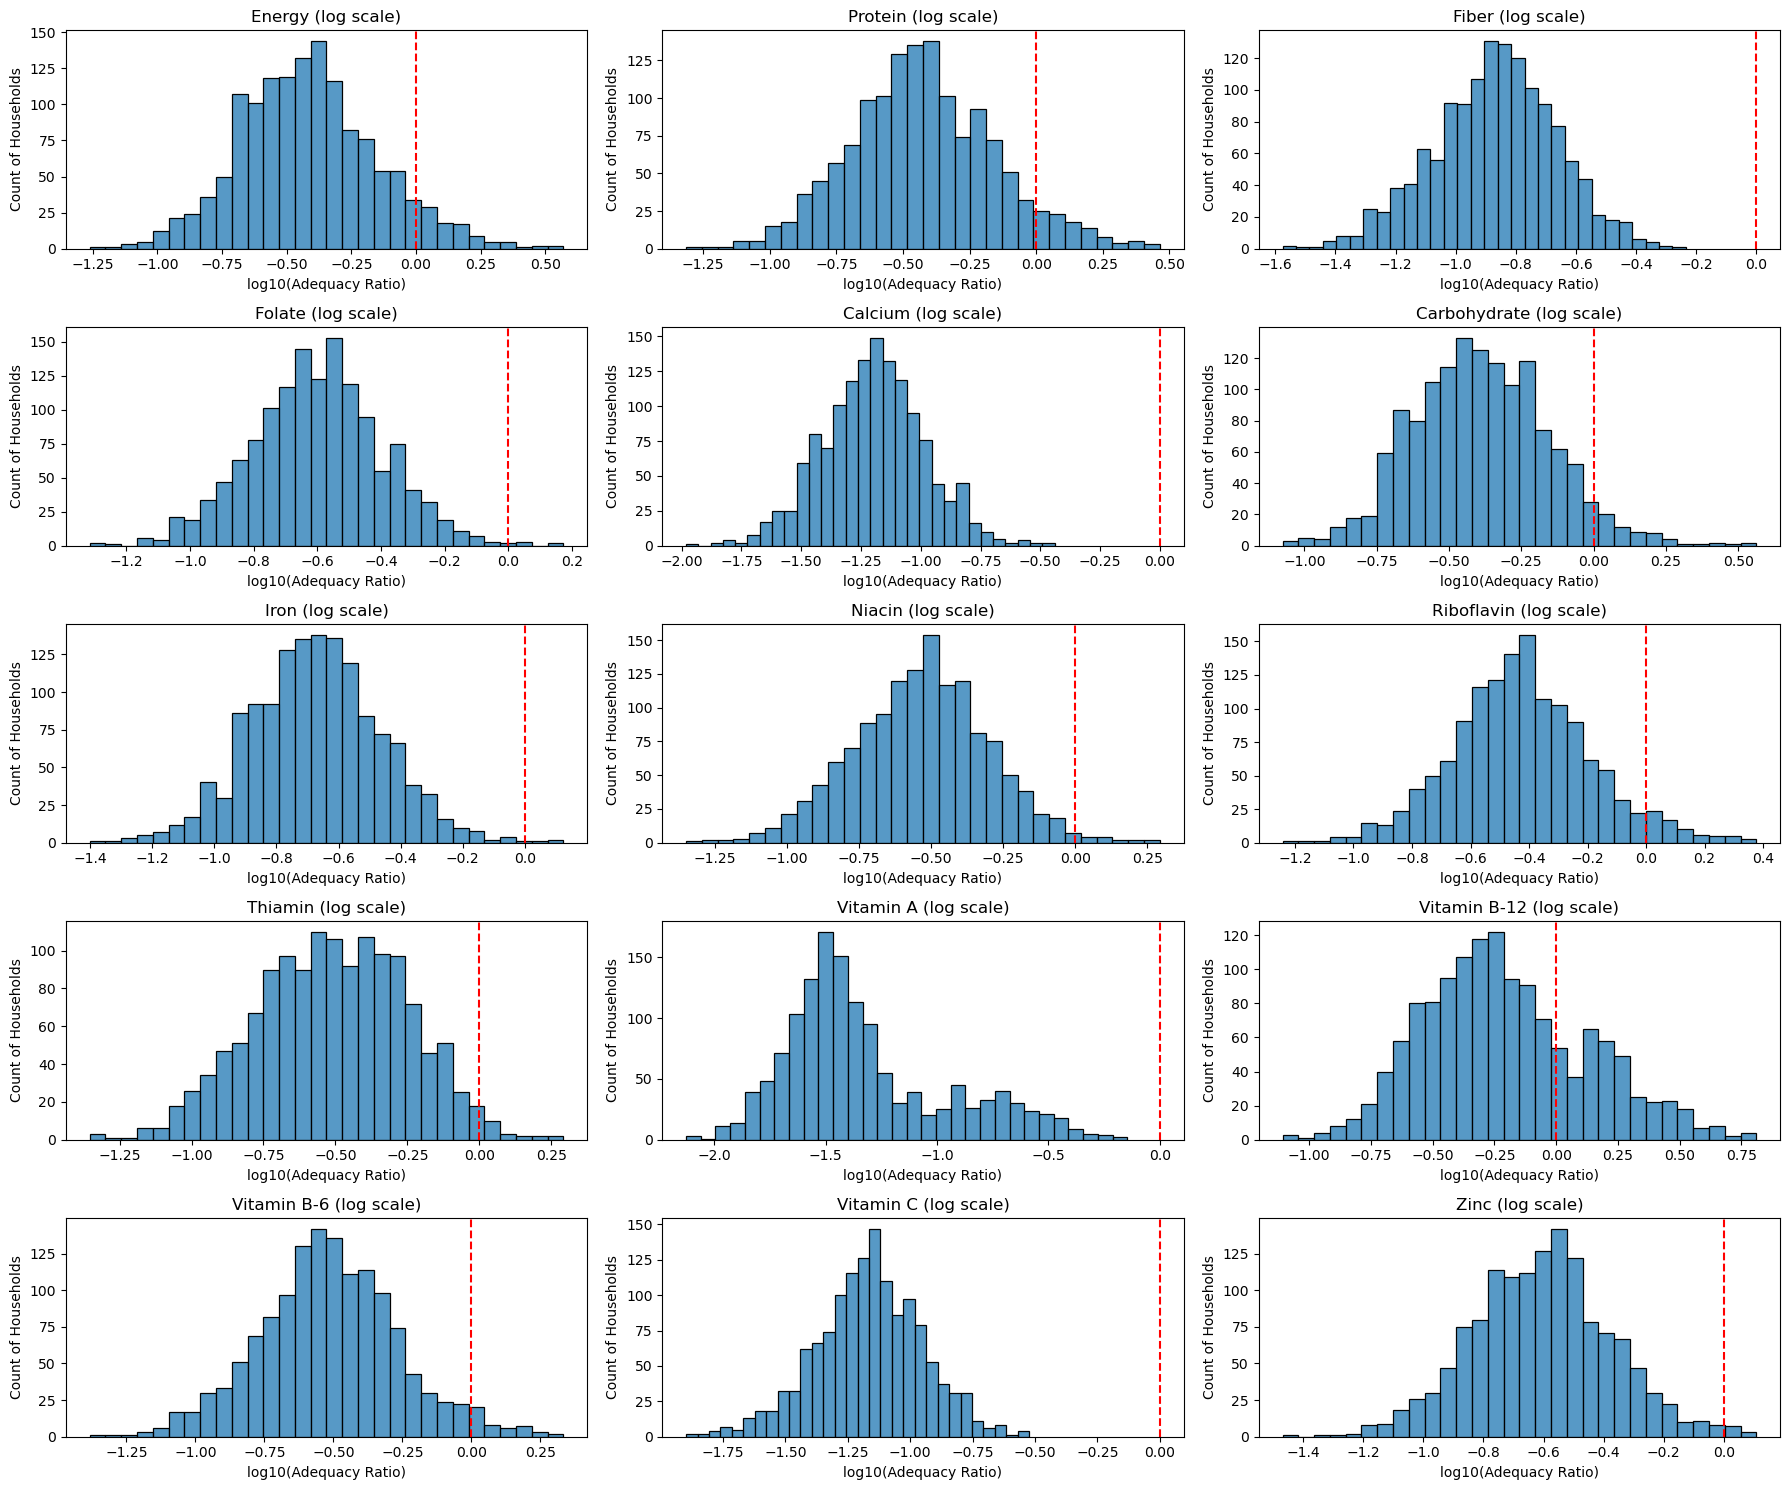

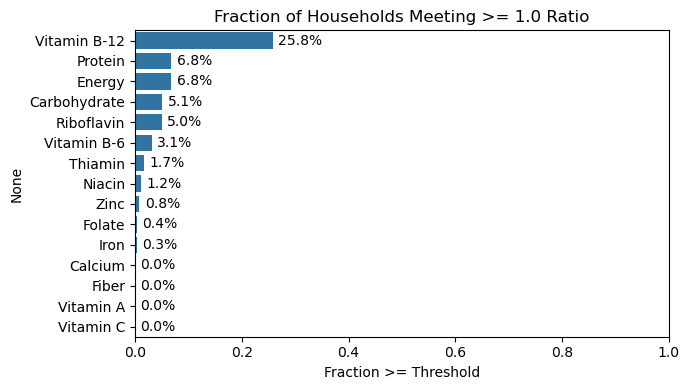

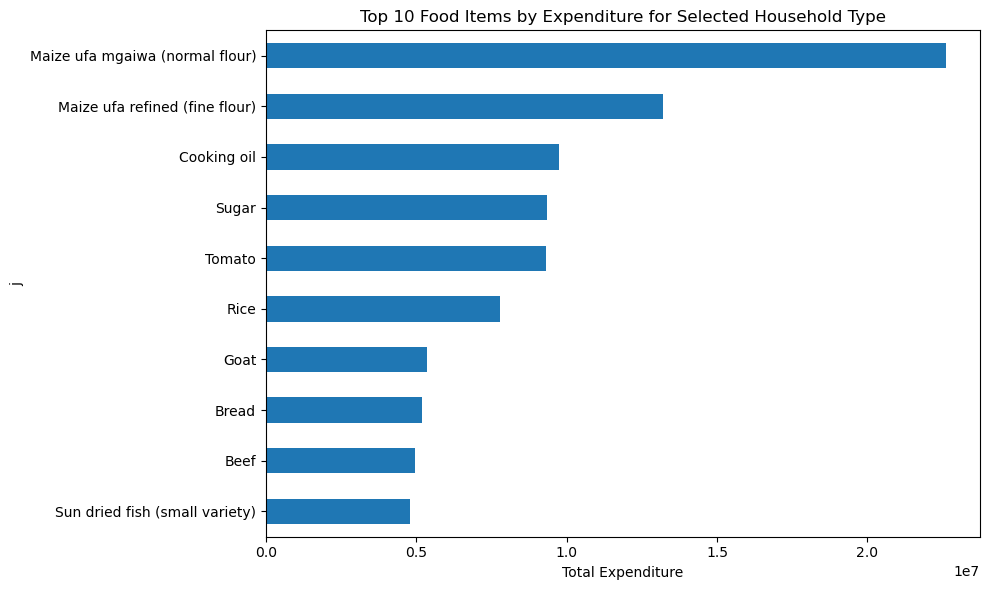

j
Maize ufa mgaiwa (normal flour)    22614580.0
Maize ufa refined (fine flour)     13213775.0
Cooking oil                         9755763.0
Sugar                               9331447.0
Tomato                              9306592.0
Rice                                7797477.0
Goat                                5357271.0
Bread                               5180935.0
Beef                                4957586.0
Sun dried fish (small variety)      4796095.0
dtype: float64

In [90]:
hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=0, max_males=1,       
    min_females=2, max_females=100,   
    min_kids=1, max_kids=100        
)
print(f'# households:{hhc_sub.shape}')
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')
analyze_nutritional_adequacy_subplots_log(nut_sub)
plot_top_foods_by_household(
    hhc,
    expend, 
    min_males=0, max_males=1,       # e.g. 0 adult males
    min_females=2, max_females=100,   # e.g. 1–3 adult females
    min_kids=1, max_kids=100)

#analyze_nutritional_adequacy(nut_sub)

# Changes in nutritional adequacy over time

In [91]:

avg_per_year = nutrtional_ratio_combined.groupby('t').mean()
avg_per_year

n          Energy   Protein     Fiber    Folate   Calcium  Carbohydrate  \
t                                                                         
2004-05  0.670794  0.963853  0.187520  0.402628  0.113745      0.490129   
2010-11  1.149384  0.789881  0.221591  0.476395  0.115594      1.187627   
2016-17  0.467562  0.443379  0.191550  0.344406  0.093867      0.461582   
2019-20  0.384732  0.317839  0.172521  0.326826  0.082797      0.585292   

n            Iron    Niacin  Riboflavin   Thiamin  Vitamin A  Vitamin B-12  \
t                                                                            
2004-05  0.424159  0.419832    0.881099  0.388776   0.265323      2.186789   
2010-11  0.513004  0.636622    0.659990  0.559031   0.055235      1.736487   
2016-17  0.316126  0.432164    0.452190  0.616931   0.040140      0.551887   
2019-20  0.301462  0.324751    0.380440  0.316212   0.039460      0.564126   

n        Vitamin B-6  Vitamin C      Zinc  
t                                          
2004-05     0.726301   0.119366  0.428614  
2010-11     0.626834   0.107917  0.538641  
2016-17     0.402181   0.090752  0.297353  
2019-20     0.275794   0.078157  0.251114

In [94]:
import pandas as pd
import plotly.express as px

# Reset index and convert 't' to string/categorical
df = avg_per_year.reset_index()
df['t'] = df['t'].astype(str)  # or use: df['t'] = pd.Categorical(df['t'], ordered=True)

# Melt to long format
df_long = df.melt(id_vars='t', var_name='Nutrient', value_name='Adequacy Ratio')

# Create interactive plot with x as categorical
fig = px.line(
    df_long,
    x='t',
    y='Adequacy Ratio',
    color='Nutrient',
    markers=True,
    title='Average Nutrient Adequacy Ratios by Year'
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Adequacy Ratio',
    legend_title='Nutrient',
    hovermode='x unified',
    xaxis=dict(type='category')  # Force x-axis to be discrete
)

fig.show()


In [95]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_nutritional_adequacy_subplots_log(
    nut_df,
    adequacy_threshold=1.0,  # We'll draw a vertical line at log10(1.0) = 0
    bins=30,
    n_cols=3
):
    """
    Create subplots of histograms for each nutrient ratio, using log10 scale.
    We drop any rows where a nutrient ratio <= 0 to avoid log(0) or log(negative).
    
    Parameters:
    -----------
    nut_df : pd.DataFrame
        DataFrame of nutrient adequacy ratios, with each column a nutrient.
    adequacy_threshold : float
        We'll add a vertical line at log10(adequacy_threshold).
        e.g. if threshold=1.0, the line is at x=0. 
    bins : int
        Number of histogram bins.
    n_cols : int
        Number of columns of subplots (we auto-calc rows).
    """

    # 1) Filter out rows where any ratio <= 0
    #    (log10 is undefined for non-positive values)
    mask = (nut_df > 0).all(axis=1)
    df_pos = nut_df[mask].copy()
    
    # 2) Decide which columns to plot (skip any columns like 'n' if needed)
    plot_cols = [c for c in df_pos.columns if c not in ["n"]]
    
    # 3) Compute log10 for each plotted nutrient
    for col in plot_cols:
        df_pos["log10_" + col] = np.log10(df_pos[col])

    # 4) Create subplots: N rows x n_cols
    n_rows = math.ceil(len(plot_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharey=False)
    axes = axes.flatten()

    log_threshold = np.log10(adequacy_threshold)

    # 5) For each nutrient column, plot histogram of log10(ratio)
    for i, col in enumerate(plot_cols):
        ax = axes[i]
        sns.histplot(df_pos["log10_" + col], bins=bins, kde=False, ax=ax)
        ax.axvline(log_threshold, color="red", linestyle="--")
        ax.set_title(f"{col} (log scale)")
        ax.set_xlabel("log10(Adequacy Ratio)")
        ax.set_ylabel("Count of Households")

    # Hide extra subplot axes if the # of nutrients isn't a multiple of n_cols
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

     # 3) Compute fraction that meet/exceed threshold
    fraction_meeting = {}
    for col in nut_df.columns:
        if col in ("n",):  # skip non‐ratio columns
            continue
        # fraction of households with ratio >= threshold
        fraction_meeting[col] = (nut_df[col] >= adequacy_threshold).mean()

    # Turn this into a DataFrame for easy plotting
    frac_df = pd.DataFrame.from_dict(fraction_meeting, orient="index", columns=["Fraction >= Threshold"])
    frac_df = frac_df.sort_values("Fraction >= Threshold", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=frac_df["Fraction >= Threshold"], y=frac_df.index, orient="h")
    plt.title(f"Fraction of Households Meeting >= {adequacy_threshold} Ratio")
    plt.xlim(0, 1)  # fraction from 0 to 1
    for i, val in enumerate(frac_df["Fraction >= Threshold"]):
        plt.text(val + 0.01, i, f"{val:.1%}", va='center')  # label with percentage
    plt.tight_layout()
    plt.show()


# Regional Differences
## Note: lots of nuance lost in splitting into regions. Quick tool to see the range of differences

In [ ]:
hhc

In [ ]:
expend

In [ ]:
import pandas as pd
import plotly.express as px
import json

with open("sn.json") as f:
    senegal_geo = json.load(f)
# Or using geopandas:
gdf = gpd.read_file("sn.json")


# 3) Create the choropleth
#    We'll use an animation slider for nutrient selection. Each "frame" in the slider is a different nutrient.
fig = px.choropleth(
    region_nutrient_df,
    geojson=senegal_geo,
    locations='region',         # Column in region_nutrient_df that matches GeoJSON features' property
    featureidkey='properties.region_name_in_geojson', 
    # ^^^ Adjust to the property name in your geojson that stores the region's name. 
    color='fraction_meeting',
    color_continuous_scale='YlOrRd',
    range_color=(0,1),          # fraction_meeting from 0% to 100% (0-1)
    scope='africa',             # "africa" or use fig.update_geos(...)
    hover_name='region',        # Display region name on hover
    animation_frame='nutrient', # This tells Plotly to create an animation slider for different nutrients
)

# 4) Customize the hover template, layout, etc.
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>" +
                  "Fraction meeting: %{z:.1%}<extra></extra>"
)
fig.update_layout(
    title="Senegal: % of Households Meeting Recommended Nutrient Intake",
    margin={"r":0,"t":50,"l":0,"b":0}
)
fig.update_geos(fitbounds="locations", visible=False)

fig.show()


In [ ]:
def filter_regions(hhc, nutrient_ratio, regions):
    """
    Return rows (households) from hhc and nutrient_ratio
    where the 'm' index level is in the given list of regions.

    Both DataFrames must be MultiIndexed by (i, t, m).
    """

    # 1) Build a Boolean mask selecting only desired regions
    #    We take the 'm' level of the index and check if it is in `regions`.
    mask = hhc.index.get_level_values('m').isin(regions)

    # 2) Apply this mask to both dataframes
    hhc_filtered = hhc.loc[mask].copy()

    # 3) Intersection with nutrient_ratio's index
    #    so we only keep households that exist in BOTH data frames.
    common_idx = hhc_filtered.index.intersection(nutrient_ratio.index)
    hhc_filtered = hhc_filtered.loc[common_idx]
    nutrient_filtered = nutrient_ratio.loc[common_idx]

    return hhc_filtered, nutrient_filtered

    #nutrient_filtered = nutrient_ratio.loc[mask].copy()

    #return hhc_filtered, nutrient_filtered


In [ ]:
hhc.index.get_level_values("m").unique()

In [ ]:
nutrient_ratio

# Urban regions

In [ ]:
hhc_sub, nutrient_sub = filter_regions(hhc, nutrient_ratio, ['dakar'])
analyze_nutritional_adequacy_subplots_log(nutrient_sub)

In [ ]:
hhc_sub.shape

# More Rural Regions 

In [ ]:
hhc_sub, nutrient_sub = filter_regions(hhc, nutrient_ratio, rural_regions)
analyze_nutritional_adequacy_subplots_log(nutrient_sub)



In [ ]:
hhc_sub.shape